### 説明

- 以前扱ったSARIMAなどのモデリングは「データが生まれた背景を知ること」に重きを置いた方法**（AIの結果を元に、人間が判断）**
- ディープラーニングは「精度の良い予測」に重きを置いた方法**（AIがすべて判断）**


- 時系列のディープラーニングには通常RNN（Recurrent neural network）が使用される
- その中でも、今回はより高精度が出やすいと言われるLSTM(Long Short-Term Memory)を使用


### ライブラリ&データの準備

In [84]:
#いろいろインポート
import tensorflow as tf
import pandas as pd
import numpy as np
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt

#データ読み込み
df = pd.read_csv("3-4_TS_sample2.csv",index_col="年月日",encoding="shift_jis",parse_dates=True)
#df = df[["平均気温(℃)"]] #とりあえず1つに絞る

df_week = df.resample("W").mean() #週ごとに集計

#0〜1にスケーリング
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
df_week_scale = pd.DataFrame(scaler.fit_transform(df_week),index=df_week.index,columns=df_week.columns)

#学習データ、試験データに分離
df_week_scale_train = df_week_scale["2010":"2018"]
df_week_scale_test = df_week_scale["2019"]


### RNN用入力データへの整形

kerasの場合、入力データを

X = [

[[時点1におけるx1,時点1におけるx2,...],[時点2におけるx1,時点2におけるx2,...],...,[時点30におけるx1,時点30におけるx2,...]],

[[時点2におけるx1,時点2におけるx2,...],[時点3におけるx1,時点3におけるx2,...],...,[時点31におけるx1,時点31におけるx2,...]],

[[時点3におけるx1,時点3におけるx2,...],[時点4におけるx1,時点4におけるx2,...],...,[時点32におけるx1,時点32におけるx2,...]],

...

]

y = [

[[時点31におけるy]],

[[時点32におけるy]],

[[時点33におけるy]],

...

]


という形状にする必要がある。

In [85]:
look_back = 30 #どれくらい過去まで見るか

def create_input_data(data, look_back):    
    raw_data = data.T.values.tolist()
    data_size = len(data) - look_back

    X = [[] for i in range(len(raw_data))] 
    y = [[] for i in range(len(raw_data))] 

    for i in range(data_size):
        for j in range(len(raw_data)):
            X[j].append(raw_data[j][i:i + look_back])
            y[j].append([raw_data[j][i + look_back]])

    X_tmp = X[-1]
    y_tmp = y[-1]
    
    for i in range(len(raw_data)-1):
        X_tmp = np.insert(X_tmp,np.arange(0, (look_back-1)*(i+1)+1, i+1),X[-i-2],axis=1)
        y_tmp = np.insert(y_tmp,np.arange(0, (i+1), i+1),y[-i-2],axis=1)
    
    X = np.array(X_tmp).reshape(data_size, look_back, len(raw_data))
    y = np.array(y_tmp).reshape(data_size, 1, len(raw_data))
    
    return y, X

y_train,X_train = create_input_data(
    data=df_week_scale_train,
    look_back=look_back
)

y_test,X_test = create_input_data(
    data=df_week_scale_test,
    look_back=look_back
)


### モデル定義

In [86]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.layers import LSTM
from tensorflow.keras.optimizers import Adam

model = Sequential()
x = model.add(LSTM(10, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(LSTM(8))
model.add(Dense(len(df.columns))) #出力層はデータ数に合わせる

model.compile(loss='mean_squared_error', optimizer='adam')

### 学習実行

In [87]:
history = model.fit(X_train, y_train, epochs=100, batch_size=1)

Epoch 1/100
440/440 [==============================] - 5s 7ms/step - loss: 0.0423
Epoch 2/100
440/440 [==============================] - 3s 7ms/step - loss: 0.0167
Epoch 3/100
440/440 [==============================] - 3s 7ms/step - loss: 0.0143
Epoch 4/100
440/440 [==============================] - 3s 7ms/step - loss: 0.0170
Epoch 5/100
440/440 [==============================] - 3s 7ms/step - loss: 0.0183
Epoch 6/100
440/440 [==============================] - 3s 7ms/step - loss: 0.0164
Epoch 7/100
440/440 [==============================] - 3s 7ms/step - loss: 0.0162
Epoch 8/100
440/440 [==============================] - 3s 7ms/step - loss: 0.0180
Epoch 9/100
440/440 [==============================] - 3s 7ms/step - loss: 0.0177
Epoch 10/100
440/440 [==============================] - 3s 7ms/step - loss: 0.0169
Epoch 11/100
440/440 [==============================] - 3s 7ms/step - loss: 0.0165
Epoch 12/100
440/440 [==============================] - 3s 7ms/step - loss: 0.0172
Epoch 13/100


### 精度の確認

In [89]:
model.evaluate(X_test,y_test,batch_size=1)

22/22 [==============================] - 2s 5ms/step - loss: 0.0279


0.027917517349123955

### 学習曲線の確認

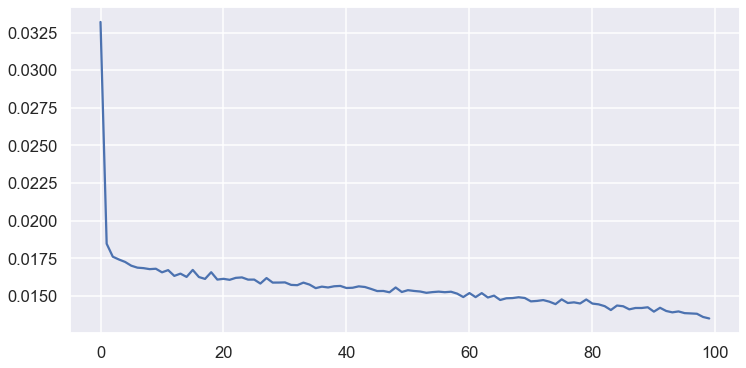

In [90]:
sns.set(context="talk")
fig = plt.subplots(figsize=(12,6))
plt.plot(history.history['loss'])

### 予測

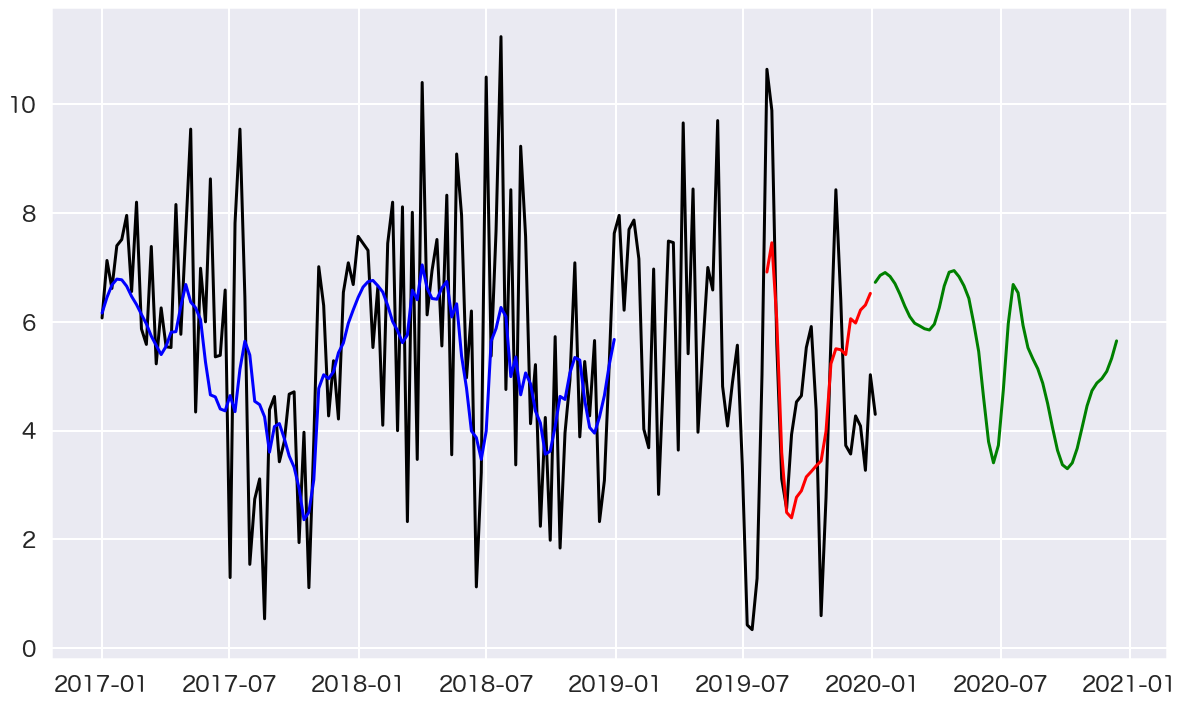

In [94]:
sns.set(context="poster",font="Hiragino Maru Gothic Pro")
fig = plt.subplots(figsize=(20,12))

#正解のプロット
df_week = pd.DataFrame(scaler.inverse_transform(df_week_scale),
                       index=df_week.index,columns=df_week.columns)
plt.plot(df_week["2017":]["日照時間(時間)"],color="black")

#学習用データ予測結果のプロット
df_week_train_pred = pd.DataFrame(scaler.inverse_transform(model.predict(X_train)),
                                  index=df_week_scale_train.index[look_back:],columns=df_week_scale_train.columns)
plt.plot(df_week_train_pred["2017":]["日照時間(時間)"],color="blue")

#評価用データ予測結果のプロット
df_week_test_pred = pd.DataFrame(scaler.inverse_transform(model.predict(X_test)),
                                 index=df_week_scale_test.index[look_back:],columns=df_week_scale_test.columns)
plt.plot(df_week_test_pred["2017":]["日照時間(時間)"],color="red")

#未来予測
future_steps = 50
X_future = [df_week_scale_test[-look_back:].values.tolist()]
y_future_list = []

for step in range(future_steps):
    y_future = model.predict(X_future)
    y_future_list.append(y_future[0])
    X_future = [X_future[0][1:] + y_future.tolist()]
    
df_week_future = pd.DataFrame(scaler.inverse_transform(y_future_list),
                              index=pd.date_range('2020-01-01', periods=future_steps, freq='W'),columns=df_week.columns)
plt.plot(df_week_future["2017":]["日照時間(時間)"],color="green")